# Training models

## Imports

In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
from data_preprocessing import (
    full_pipeline,
    split_classif_reg_targets,
)
from random_forest import run_experiment as run_random_forest_experiment
from random_forest import benchmark_random_forest
from two_stage import run_experiment as run_two_stage_experiment
from two_stage import benchmark_2s_model_grid, benchmark_2s_param_grid
from xg_boost import run_experiment as run_xgboost_experiment
from xg_boost import benchmark_xgboost
from nn import run_experiment as run_nn_experiment
from nn import  submit_nn
from linreg import run_experiment as run_linreg_experiment
from utils import write_submissions, evaluate_model, stratify_by_humidity
import torch

## Load and prepare data

In [2]:
data_dir = "./data/"
train_x_path = os.path.join(data_dir, "x_train_T9QMMVq.csv")
train_y_path = os.path.join(data_dir, "y_train_R0MqWmu.csv")
test_x_path = os.path.join(data_dir, "x_test_9F13O5s.csv")

In [ ]:
params_pipeline = {
    "split_humidity": True,
    "h_threshold": 0.211,
    "split": False,
    "val_proportion": 0.75,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": False,
    "polynomial_degree": 2,
    "include_group_interactions": True,
    "include_humidity_interactions": True,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
}

test_params_pipeline = params_pipeline.copy()
test_params_pipeline["split"] = False
test_params_pipeline["split_humidity"] = False

x_train, y_train, x_val, y_val = full_pipeline(
    train_x_path, train_y_path, **params_pipeline
)
x_test = full_pipeline(test_x_path, None, **test_params_pipeline)

# Create stratified validation sets
# x_val_strata, y_val_strata, labels = stratify_by_humidity(x_val, y_val, n_strata=5)

print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)
print("X val shape:", x_val.shape)
print("Y val shape:", y_val.shape)
print("---")
print("X test shape:", x_test.shape)
print("---")

X train shape: (163548, 14)
Y train shape: (163548, 23)
X val shape: (39385, 14)
Y val shape: (39385, 23)
---
X test shape: (134673, 14)
---


In [3]:
params_pipeline_feateng = {
    "split_humidity": True,
    "h_threshold": 0.211,
    "split": False,
    "val_proportion": 0.75,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": True,
    "polynomial_degree": 1,
    "include_group_interactions": False,
    "include_humidity_interactions": True,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
}

feat_eng = True
if feat_eng:
    x_train_eng, y_train_eng, x_val_eng, y_val_eng = full_pipeline(
        train_x_path, train_y_path, **params_pipeline_feateng
    )
    x_test_eng = full_pipeline(test_x_path, None, **params_pipeline_feateng)
else:
    x_train_eng, y_train_eng, x_val_eng, y_val_eng = x_train, y_train, x_val, y_val
    x_test_eng = x_test
print("Train shape:", x_train_eng.shape)
print("Val shape:", x_val_eng.shape)
assert x_train_eng.shape[1] == x_test_eng.shape[1], (
    f"x_train and x_test have different number of features: "
    f"{x_train_eng.shape[1]} != {x_test_eng.shape[1]}."
    f"'ID' in train: {('ID' in x_train_eng.columns)},"
    f"'ID' in test: {('ID' in x_test_eng.columns)}."
)

Train shape: (163548, 40)
Val shape: (39385, 40)


## Standard Regressors

### Random Forest Regressor

In [4]:
print("Basic Random Forest")
rf_model = run_random_forest_experiment(x_train, y_train, x_val, y_val)

Basic Random Forest
Training Weighted RMSE: 0.1161
Validation Weighted RMSE: 0.1556


In [21]:
print("Basic Random Forest with Feature Engineering")
rf_model_eng = run_random_forest_experiment(x_train_eng, y_train_eng, x_val_eng, y_val_eng)

Basic Random Forest with Feature Engineering
Training Weighted RMSE: 0.1108
Validation Weighted RMSE: 0.1455


In [24]:
x_train_eng.columns

Index(['ID', 'Humidity', 'M12', 'M13', 'M14', 'M15', 'M4', 'M5', 'M6', 'M7',
       'R', 'S1', 'S2', 'S3', 'Humidity_squared', 'Humidity_sqrt',
       'Humidity_M12_product', 'Humidity_M13_product', 'Humidity_M14_product',
       'Humidity_M15_product', 'Humidity_M4_product', 'Humidity_M5_product',
       'Humidity_M6_product', 'Humidity_M7_product', 'Humidity_R_product',
       'Humidity_S1_product', 'Humidity_S2_product', 'Humidity_S3_product',
       'Humidity_M12_ratio', 'Humidity_M13_ratio', 'Humidity_M14_ratio',
       'Humidity_M15_ratio', 'Humidity_M4_ratio', 'Humidity_M5_ratio',
       'Humidity_M6_ratio', 'Humidity_M7_ratio', 'Humidity_R_ratio',
       'Humidity_S1_ratio', 'Humidity_S2_ratio', 'Humidity_S3_ratio'],
      dtype='object')

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [7, 10, 15, None],
    "min_samples_split": [0.005, 0.01, 0.02],
    "min_samples_leaf": [20, 30, 50],
}
benchmark = False
if benchmark:
    try:
        best_model_rf, best_params_rf, best_val_rmse_rf = benchmark_random_forest(
            x_train,
            y_train,
            x_val,
            y_val,
            param_grid=param_grid,
            verbose=False,
            subset_humidity=False,
        )
    except KeyboardInterrupt:
        print("KeyboardInterrupt: Stopping the benchmarking process.")

In [4]:
best_params = {
    "n_estimators": 100,
    "max_depth": None,
    "min_samples_split": 0.005,
    "min_samples_leaf": 20,
    "random_state": 29,
    "n_jobs": -1,
}

best_rf_model = run_random_forest_experiment(
    x_train, y_train, x_val, y_val, params=best_params
)

Training Weighted RMSE: 0.0687
Validation Weighted RMSE: 0.1169


### XGBoost

In [5]:
param_grid = {
    "n_estimators": [100],
    "max_depth": [7, 10, 15],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    # "min_child_weight": [5, 10, 15],
    # "gamma": [0, 0.1, 0.2],
    # "reg_alpha": [0, 0.1, 0.2],
    # "reg_lambda": [1, 1.5, 2],
}
benchmark=False
if benchmark:
    best_xgb_model, best_xgb_params, best_val_rmse_xgb = benchmark_xgboost(
        x_train,
        y_train,
        x_val,
        y_val,
        param_grid=param_grid,
        verbose=False,
        subset_humidity=False,
    )

In [4]:
print(best_xgb_params)
print(best_val_rmse_xgb)

{'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 29, 'n_jobs': -1, 'tree_method': 'approx', 'max_bin': 64, 'scale_pos_weight': 1, 'process_type': 'default', 'predictor': 'cpu_predictor', 'grow_policy': 'depthwise'}
0.03559214381771881


In [6]:
params = {
    "n_estimators": 100,
    "max_depth": 7,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 29,
    "n_jobs": -1,
}
try:
    xgb = run_xgboost_experiment(x_train, y_train, x_val, y_val, params=params)
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training.")

Training Weighted RMSE (XGBoost): 0.0218
Validation Weighted RMSE (XGBoost): 0.0379


### Multi Linear Regression with feature selection

In [ ]:
try:
    linear_model = run_linreg_experiment(x_train_eng, y_train_eng, x_val_eng, y_val_eng, alpha=0.05)
except KeyboardInterrupt:
    print("KeyboardInterrupt received. Stopping training.")

Train shape: (163548, 182)
Val shape: (39385, 182)
Training SelectiveLinearRegressor model...


  4%|▍         | 1/23 [00:09<03:39,  9.97s/it]

KeyboardInterrupt received. Stopping training.


In [26]:
try:
    linear_model = run_linreg_experiment(x_train_eng, y_train_eng, x_val_eng, y_val_eng, alpha=0.05)
except KeyboardInterrupt:
    print("KeyboardInterrupt received. Stopping training.")

Training SelectiveLinearRegressor model...


 61%|██████    | 14/23 [00:06<00:04,  2.05it/s]/Users/kiki/.pyenv/versions/idgaz/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Feature selection results:
c01: 37 features selected - R^2 before selection: 0.6581573911363705 - R^2 after selection: 0.6581461253456412
c02: 35 features selected - R^2 before selection: 0.19957698856481 - R^2 after selection: 0.19922571629176344
c03: 35 features selected - R^2 before selection: 0.48478437860224344 - R^2 after selection: 0.4847664062661967
c04: 35 features selected - R^2 before selection: 0.48478437860224344 - R^2 after selection: 0.4847664062661967
c05: 39 features selected - R^2 before selection: 0.33020189468184 - R^2 after selection: 0.33020189468184
c06: 39 features selected - R^2 before selection: 0.33020189468184 - R^2 after selection: 0.33020189468184
c07: 35 features selected - R^2 before selection: 0.19957698856481 - R^2 after selection: 0.19922571629176344
c08: 36 features selected - R^2 before selection: 0.14681788610167879 - R^2 after selection: 0.14675225582382345
c09: 36 features selected - R^2 before selection: 0.22648060651664526 - R^2 after selection

100%|██████████| 23/23 [00:00<00:00, 149.56it/s]

Training Weighted RMSE: 0.1643
Validation Weighted RMSE: 0.1721


In [ ]:
evaluate_model(linear_model, x_val_eng, y_val_eng)

100%|██████████| 23/23 [00:00<00:00, 53.57it/s]


0.13396921310406534

In [9]:
write_submissions(
    linear_model,
    test_x_path,
    "submissions_multi_regression_feateng.csv",
    use_embed=False,
    **params_pipeline_feateng,
)

Using 181 features


100%|██████████| 23/23 [00:03<00:00,  6.03it/s]


## Deep Learning

### Rescale data (no)

In [3]:
split_humidity = True
params_pipeline_dl = {
    "split_humidity": split_humidity,
    "h_threshold": 0.211,
    "split": not split_humidity,
    "val_proportion": 0.5 if split_humidity else 0.1,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": False,
    "polynomial_degree": 1,
    "include_group_interactions": False,
    "include_humidity_interactions": False,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
}

test_params_pipeline_dl = params_pipeline_dl.copy()
test_params_pipeline_dl["split"] = False
test_params_pipeline_dl["split_humidity"] = False

x_train, y_train, x_val, y_val = full_pipeline(
    train_x_path, train_y_path, **params_pipeline_dl
)
x_test = full_pipeline(test_x_path, None, **test_params_pipeline_dl)
print("Train shape:", x_train.shape)
print("Val shape:", x_val.shape)

Train shape: (176676, 14)
Val shape: (26257, 14)


In [4]:
if not split_humidity:
    x_val_strata, y_val_strata, labels = stratify_by_humidity(x_val, y_val, n_strata=2)
    val_data = [(x_val_strata[i], y_val_strata[i]) for i in range(len(x_val_strata))]
else:
    val_data = [(x_val, y_val)]
    labels = None

In [5]:
labels

### RAMTNet
#### Without UDA

In [7]:
epochs = 60
uda = False
params_ramt = {
    "model_class": "RAMTNet",
    "model_params": {
        "num_features": x_train.drop(columns=["ID"]).shape[1],
        "num_tasks": y_train.shape[1],
        "feature_embed_dim": 16,
        "embed_dim": 128,
        "attn_heads": 4,
        "attn_blocks": 1,
        "num_res_blocks": 2,
        "head_hidden": 32,
        "dropout_rate": 0.3 if not uda else 0.1,
    },
    "training_params": {
        "n_epochs": epochs,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}

Number of trainable parameters: 191063


Epoch 60/60 - Train Loss: 0.0524, Val Loss: 0.0473, LR: 0.002500: 100%|██████████| 60/60 [12:29<00:00, 12.49s/it]


Final Validation Weighted RMSE: 0.0473


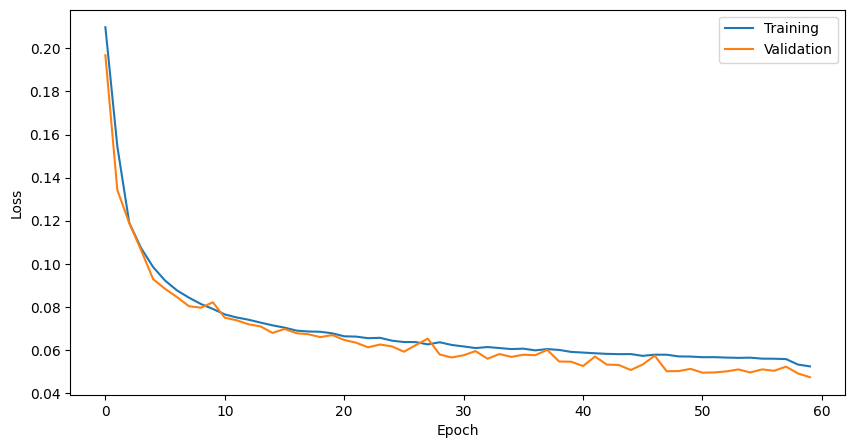

In [ ]:
try:
    ramtnet = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        params=params_ramt,
        uda=uda,
        verbose=True,
        plot_losses=True,
        labels=labels,
        lambda_domain=0.25,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [14]:
error = evaluate_model(ramtnet, x_val, y_val)
print(f"Validation error: {error}")

Validation error: 0.047338593980398


In [ ]:
u = "_uda" if uda else ""
torch.save(ramtnet.state_dict(), f"checkpoints/ramtnet{u}_base.pth")

#### With UDA

In [8]:
uda = True
params_ramt = {
    "model_class": "RAMTNet",
    "model_params": {
        "num_features": x_train.drop(columns=["ID"]).shape[1],
        "num_tasks": y_train.shape[1],
        "feature_embed_dim": 16,
        "embed_dim": 128,
        "attn_heads": 4,
        "attn_blocks": 1,
        "num_res_blocks": 2,
        "head_hidden": 32,
        "dropout_rate": 0.3 if not uda else 0.1,
    },
    "training_params": {
        "n_epochs": epochs,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}

Number of trainable parameters: 191063


Epoch 60/60 - Train Disc Acc: 53.86%, Train Disc Loss: 0.6873, Train Reg Loss: 0.1311, Train Loss: 0.3029, Val Loss: 0.1864, LR: 0.001250: 100%|██████████| 60/60 [18:42<00:00, 18.70s/it]


Final Validation Weighted RMSE: 0.1864


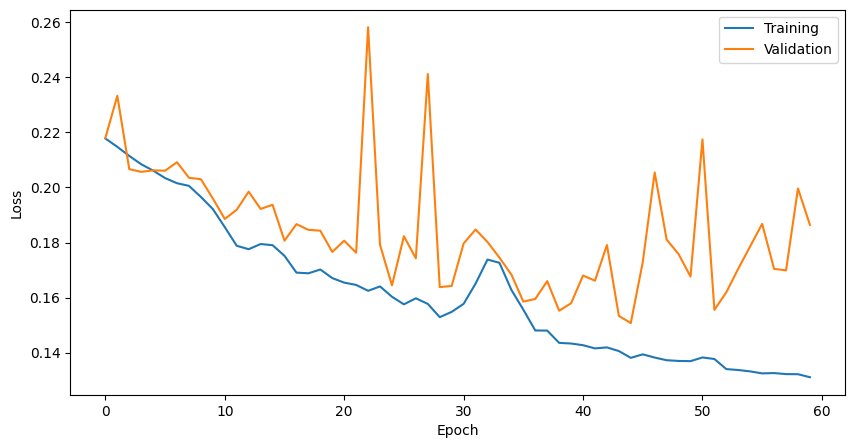

In [ ]:
try:
    ramtnet = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        params=params_ramt,
        uda=uda,
        verbose=True,
        plot_losses=True,
        labels=labels,
        lambda_domain=0.25,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [17]:
error = evaluate_model(ramtnet, x_val, y_val)
print(f"Validation error: {error}")

Validation error: 0.18635131872779223


In [ ]:
u = "_uda" if uda else ""
torch.save(ramtnet.state_dict(), f"checkpoints/ramtnet{u}_base.pth")

### RegressorV3
#### Without UDA

In [9]:
epochs = 60
uda = False
params_reg_v3 = {
    "model_class": "RegressorV3",
    "model_params": {
        "hidden_dim": 128,
        "num_output": 23,
        "humidity_dim": 32,
        "group_embed_dim": 32,
        "bias": True,
        "dropout_rate": 0.3 if not uda else 0.1,
    },
    "training_params": {
        "n_epochs": epochs,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}

Number of trainable parameters: 31927


Epoch 60/60 - Train Loss: 0.1012, Val Loss: 0.0850, LR: 0.002500: 100%|██████████| 60/60 [03:12<00:00,  3.21s/it]


Final Validation Weighted RMSE: 0.0850


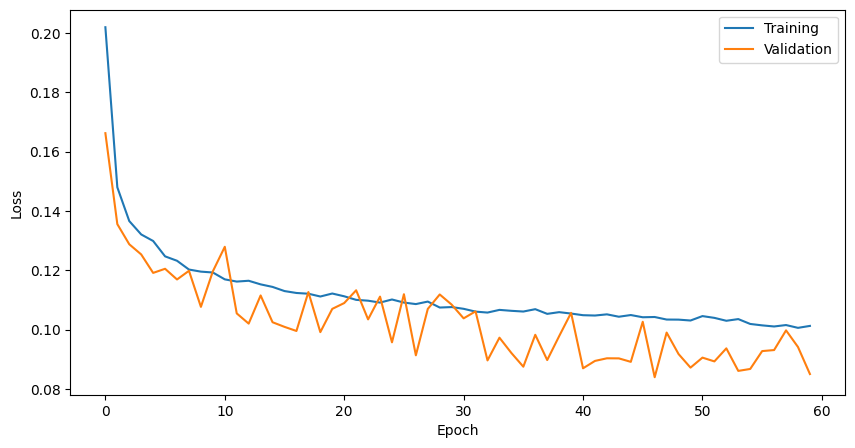

In [ ]:
try:
    reg_v3 = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=uda,
        params=params_reg_v3,
        lambda_domain=1.0,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [20]:
print(f"Weighted RMSE on validation set: {evaluate_model(reg_v3, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.0850


In [21]:
u = "uda" if uda else ""
torch.save(reg_v3.state_dict(), f"checkpoints/reg_v3_{u}_base.pth")

#### With UDA

In [10]:
uda = True
params_reg_v3 = {
    "model_class": "RegressorV3",
    "model_params": {
        "hidden_dim": 128,
        "num_output": 23,
        "humidity_dim": 32,
        "group_embed_dim": 32,
        "bias": True,
        "dropout_rate": 0.3 if not uda else 0.1,
    },
    "training_params": {
        "n_epochs": epochs,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}

Number of trainable parameters: 31927


Epoch 60/60 - Train Disc Acc: 56.47%, Train Disc Loss: 0.6730, Train Reg Loss: 0.1347, Train Loss: 0.8077, Val Loss: 0.2028, LR: 0.000078: 100%|██████████| 60/60 [06:29<00:00,  6.48s/it]


Final Validation Weighted RMSE: 0.2028


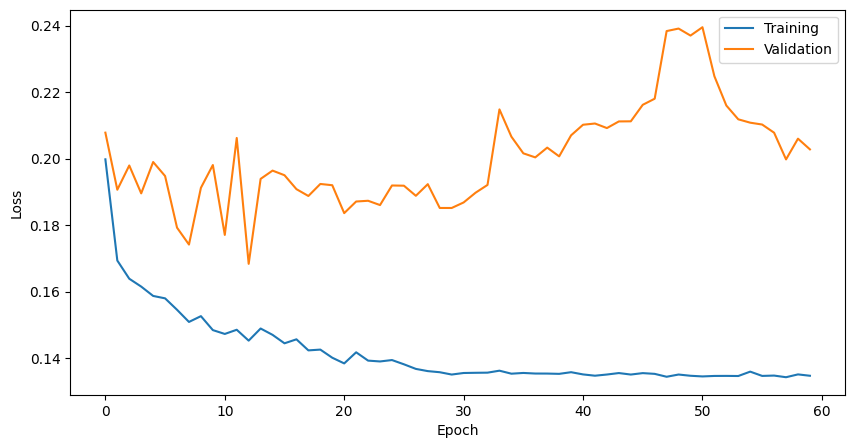

In [ ]:
try:
    reg_v3 = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=uda,
        params=params_reg_v3,
        lambda_domain=1.0,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [23]:
print(f"Weighted RMSE on validation set: {evaluate_model(reg_v3, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.2027


In [24]:
u = "uda" if uda else ""
torch.save(reg_v3.state_dict(), f"checkpoints/reg_v3_{u}_base.pth")

### NNRegressor

In [11]:
epochs = 60
params_nnreg = {
    "model_class": "NNRegressor",
    "model_params": {
        "hidden_dim": 128,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_params": {
        "n_epochs": epochs,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}

Number of trainable parameters: 12439


Epoch 60/60 - Train Loss: 0.0810, Val Loss: 0.0775, LR: 0.001250: 100%|██████████| 60/60 [02:17<00:00,  2.29s/it]


Final Validation Weighted RMSE: 0.0775


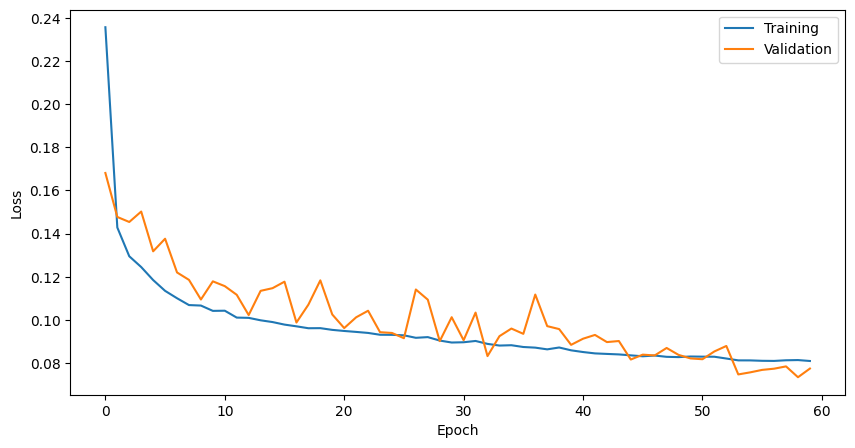

In [ ]:
try:
    nnreg = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=False,
        params=params_nnreg,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [26]:
print(f"Weighted RMSE on validation set: {evaluate_model(nnreg, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.0775


In [27]:
torch.save(nnreg.state_dict(), "checkpoints/nnreg_base.pth")

### GasDetectionModel

In [12]:
epochs = 60
params_gasdet = {
    "model_class": "GasDetectionModel",
    "model_params": {
        "hidden_dim": 128,
        "num_output": 23,
        "dropout_rate": 0.3,
    },
    "training_params": {
        "n_epochs": epochs,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}

Number of trainable parameters: 25391


Epoch 60/60 - Train Loss: 0.0628, Val Loss: 0.0569, LR: 0.001250: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it]


Final Validation Weighted RMSE: 0.0569


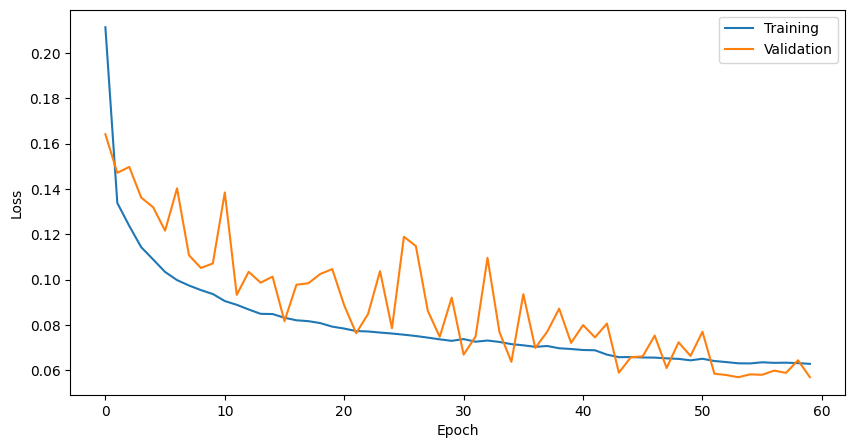

In [ ]:
try:
    gasdet = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=False,
        params=params_gasdet,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [29]:
print(f"Weighted RMSE on validation set: {evaluate_model(gasdet, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.0569


In [30]:
torch.save(gasdet.state_dict(), "checkpoints/gasdet_base.pth")

### CNN

In [13]:
epochs = 60
params_cnn = {
    "model_class": "SensorCNN",
    "model_params": {
        "input_dim": x_train.drop("ID", axis=1).shape[1],
        "embed_dim": 32,
        "conv_channels": 16,
        "final_dim": 32,
        "num_output": y_train.shape[1],
        "dropout_rate": 0.1,
    },
    "training_params": {
        "n_epochs": epochs,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 2048,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}

Number of trainable parameters: 18223


Epoch 60/60 - Train Loss: 0.1135, Val Loss: 0.1140, LR: 0.002500: 100%|██████████| 60/60 [05:17<00:00,  5.29s/it]


Final Validation Weighted RMSE: 0.1140


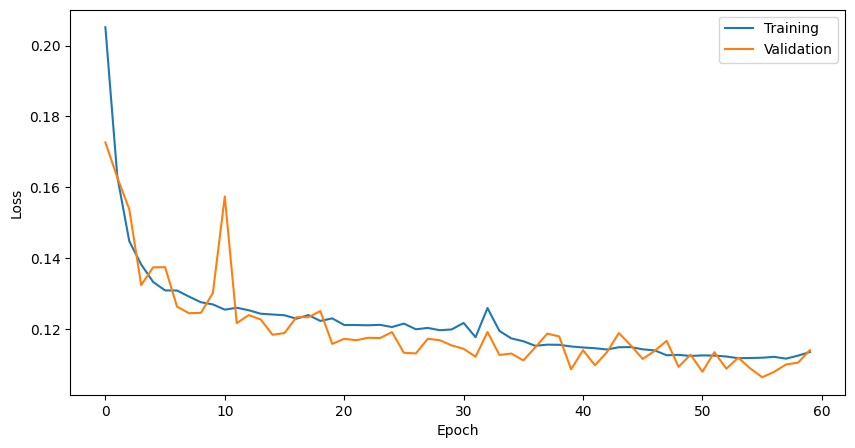

In [ ]:
try:
    cnn = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=False,
        params=params_cnn,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [32]:
error = evaluate_model(cnn, x_val, y_val)
print(f"Validation error: {error}")

Validation error: 0.11403178839624735


In [33]:
torch.save(cnn.state_dict(), "checkpoints/cnn_base.pth")

## Two-stage approach

In [4]:
y_train_classif, y_train_reg = split_classif_reg_targets(y_train)
y_val_classif, y_val_reg = split_classif_reg_targets(y_val)

In [5]:
model_grid = {
    "clf_names": ['randomforestclassifier', 'decisiontreeclassifier', 'kneighborsclassifier', 'xgbclassifier'],
    "reg_names": ['randomforestregressor', 'linearregression', 'decisiontreeregressor', 'kneighborsregressor', 'xgbregressor', 'gradientboostingregressor'],
    "clf_params": {
        "randomforestclassifier": {"n_estimators": 10, "max_depth": 10, "random_state": 29, "n_jobs": -1},
        "decisiontreeclassifier": {"max_depth": 10, "random_state": 29},
        "kneighborsclassifier": {"n_neighbors": 5, "n_jobs": -1},
        "xgbclassifier": {"n_estimators": 10, "max_depth": 10, "random_state": 29},
    },
    "reg_params": {
        "randomforestregressor": {"n_estimators": 10, "max_depth": 10, "random_state": 29, "n_jobs": -1},
        "linearregression": {"n_jobs": -1},
        "decisiontreeregressor": {"max_depth": 10, "random_state": 29},
        "kneighborsregressor": {"n_neighbors": 5, "n_jobs": -1},
        "xgbregressor": {"n_estimators": 10, "max_depth": 10, "random_state": 29, "n_jobs": -1},
        "gradientboostingregressor": {"n_estimators": 10, "max_depth": 10, "random_state": 29},
    }
}

try:
    best_model_2s, best_params_2s, best_val_rmse_2s = benchmark_2s_model_grid(
        x_train,
        y_train,
        y_train_classif,
        y_train_reg,
        x_val,
        y_val,
        y_val_classif,
        y_val_reg,
        model_grid,
        verbose=True,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping the benchmarking process.")

Model Grid Search:   4%|▍         | 1/24 [00:09<03:32,  9.24s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'randomforestregressor'
Training Weighted RMSE: 0.0491
Validation Weighted RMSE: 0.0899
--------------------------------------------------


Model Grid Search:   8%|▊         | 2/24 [00:14<02:37,  7.17s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'linearregression'
Training Weighted RMSE: 0.1213
Validation Weighted RMSE: 0.1480
--------------------------------------------------


Model Grid Search:  12%|█▎        | 3/24 [00:22<02:34,  7.36s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'decisiontreeregressor'
Training Weighted RMSE: 0.0549
Validation Weighted RMSE: 0.0971
--------------------------------------------------


Model Grid Search:  17%|█▋        | 4/24 [00:31<02:36,  7.81s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'kneighborsregressor'
Training Weighted RMSE: 0.0307
Validation Weighted RMSE: 0.0734
--------------------------------------------------


Model Grid Search:  21%|██        | 5/24 [00:39<02:30,  7.94s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'xgbregressor'
Training Weighted RMSE: 0.0322
Validation Weighted RMSE: 0.0712
--------------------------------------------------


Model Grid Search:  25%|██▌       | 6/24 [01:00<03:44, 12.46s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'gradientboostingregressor'
Training Weighted RMSE: 0.0663
Validation Weighted RMSE: 0.0935
--------------------------------------------------


Model Grid Search:  29%|██▉       | 7/24 [01:08<03:07, 11.05s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'randomforestregressor'
Training Weighted RMSE: 0.0554
Validation Weighted RMSE: 0.0927
--------------------------------------------------


Model Grid Search:  33%|███▎      | 8/24 [01:13<02:27,  9.23s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'linearregression'
Training Weighted RMSE: 0.1235
Validation Weighted RMSE: 0.1480
--------------------------------------------------


Model Grid Search:  38%|███▊      | 9/24 [01:20<02:07,  8.53s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'decisiontreeregressor'
Training Weighted RMSE: 0.0607
Validation Weighted RMSE: 0.0994
--------------------------------------------------


Model Grid Search:  42%|████▏     | 10/24 [01:29<01:57,  8.39s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'kneighborsregressor'
Training Weighted RMSE: 0.0405
Validation Weighted RMSE: 0.0774
--------------------------------------------------


Model Grid Search:  46%|████▌     | 11/24 [01:35<01:42,  7.92s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'xgbregressor'
Training Weighted RMSE: 0.0413
Validation Weighted RMSE: 0.0745
--------------------------------------------------


Model Grid Search:  50%|█████     | 12/24 [01:56<02:21, 11.76s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'gradientboostingregressor'
Training Weighted RMSE: 0.0705
Validation Weighted RMSE: 0.0947
--------------------------------------------------


Model Grid Search:  54%|█████▍    | 13/24 [05:48<14:23, 78.54s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'randomforestregressor'
Training Weighted RMSE: 0.0438
Validation Weighted RMSE: 0.0738
--------------------------------------------------


Model Grid Search:  58%|█████▊    | 14/24 [09:36<20:37, 123.77s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'linearregression'
Training Weighted RMSE: 0.1195
Validation Weighted RMSE: 0.1401
--------------------------------------------------


Model Grid Search:  62%|██████▎   | 15/24 [13:35<23:46, 158.52s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'decisiontreeregressor'
Training Weighted RMSE: 0.0503
Validation Weighted RMSE: 0.0827
--------------------------------------------------


Model Grid Search:  67%|██████▋   | 16/24 [17:36<24:25, 183.20s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'kneighborsregressor'
Training Weighted RMSE: 0.0202
Validation Weighted RMSE: 0.0488
--------------------------------------------------


Model Grid Search:  71%|███████   | 17/24 [21:27<23:02, 197.49s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'xgbregressor'
Training Weighted RMSE: 0.0226
Validation Weighted RMSE: 0.0465
--------------------------------------------------


Model Grid Search:  75%|███████▌  | 18/24 [25:32<21:11, 211.89s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'gradientboostingregressor'
Training Weighted RMSE: 0.0624
Validation Weighted RMSE: 0.0782
--------------------------------------------------


Model Grid Search:  79%|███████▉  | 19/24 [25:59<13:02, 156.41s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'randomforestregressor'
Training Weighted RMSE: 0.0431
Validation Weighted RMSE: 0.0717
--------------------------------------------------


Model Grid Search:  83%|████████▎ | 20/24 [26:25<07:48, 117.07s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'linearregression'
Training Weighted RMSE: 0.1193
Validation Weighted RMSE: 0.1387
--------------------------------------------------


Model Grid Search:  88%|████████▊ | 21/24 [26:52<04:30, 90.01s/it] 


Model Combination: Classifier 'xgbclassifier' | Regressor 'decisiontreeregressor'
Training Weighted RMSE: 0.0497
Validation Weighted RMSE: 0.0809
--------------------------------------------------


Model Grid Search:  92%|█████████▏| 22/24 [27:21<02:23, 71.94s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'kneighborsregressor'
Training Weighted RMSE: 0.0187
Validation Weighted RMSE: 0.0449
--------------------------------------------------


Model Grid Search:  96%|█████████▌| 23/24 [27:49<00:58, 58.75s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'xgbregressor'
Training Weighted RMSE: 0.0214
Validation Weighted RMSE: 0.0422
--------------------------------------------------


Model Grid Search: 100%|██████████| 24/24 [28:32<00:00, 71.34s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'gradientboostingregressor'
Training Weighted RMSE: 0.0620
Validation Weighted RMSE: 0.0756
--------------------------------------------------

Best Model:
Parameters: {'clf_name': 'xgbclassifier', 'reg_name': 'xgbregressor', 'clf_params': {'n_estimators': 10, 'max_depth': 10, 'random_state': 29}, 'reg_params': {'n_estimators': 10, 'max_depth': 10, 'random_state': 29, 'n_jobs': -1}}
Validation RMSE: 0.0422
Best Model Performance on validation set:
Validation RMSE: 0.0422


In [11]:
clf_name = "kneighborsclassifier"
reg_name = "randomforestregressor"
param_grid = {
    "clf": {
        'n_neighbors': [5], 'weights': ['uniform'], 'algorithm': ['auto'],
    },
    "reg": {
        "n_estimators": [100, 200],
        "max_depth": [7, 10, 15],
        "min_samples_split": [0.005, 0.01],
        "min_samples_leaf": [30, 50],
    },
}

try:
    best_model_2s, best_params_2s, best_val_rmse_2s = benchmark_2s_param_grid(
        x_train,
        y_train,
        y_train_classif,
        y_train_reg,
        x_val,
        y_val,
        y_val_classif,
        y_val_reg,
        clf_name,
        reg_name,
        param_grid,
        verbose=True,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping the benchmarking process.")

Hyperparameter Search:   4%|▍         | 1/24 [05:10<1:58:57, 310.34s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0762
Validation Weighted RMSE: 0.1005
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:   8%|▊         | 2/24 [10:11<1:51:52, 305.11s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0760
Validation Weighted RMSE: 0.1003
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  12%|█▎        | 3/24 [14:58<1:43:48, 296.59s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0791
Validation Weighted RMSE: 0.1040
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  17%|█▋        | 4/24 [21:09<1:48:39, 325.95s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0798
Validation Weighted RMSE: 0.1051
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  21%|██        | 5/24 [27:05<1:46:39, 336.84s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0583
Validation Weighted RMSE: 0.0933
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  25%|██▌       | 6/24 [33:57<1:48:44, 362.50s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0591
Validation Weighted RMSE: 0.0940
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  29%|██▉       | 7/24 [40:10<1:43:38, 365.82s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0669
Validation Weighted RMSE: 0.1010
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  33%|███▎      | 8/24 [46:30<1:38:44, 370.25s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0672
Validation Weighted RMSE: 0.1008
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  38%|███▊      | 9/24 [51:52<1:28:47, 355.18s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0523
Validation Weighted RMSE: 0.0876
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  42%|████▏     | 10/24 [57:14<1:20:32, 345.19s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0526
Validation Weighted RMSE: 0.0883
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  46%|████▌     | 11/24 [1:02:30<1:12:50, 336.20s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0649
Validation Weighted RMSE: 0.1010
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  50%|█████     | 12/24 [1:09:22<1:11:51, 359.29s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0651
Validation Weighted RMSE: 0.1010
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  54%|█████▍    | 13/24 [1:16:10<1:08:34, 374.06s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0760
Validation Weighted RMSE: 0.1002
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  58%|█████▊    | 14/24 [1:23:26<1:05:27, 392.73s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0761
Validation Weighted RMSE: 0.1002
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  62%|██████▎   | 15/24 [1:31:13<1:02:15, 415.10s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0794
Validation Weighted RMSE: 0.1045
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  67%|██████▋   | 16/24 [1:38:58<57:19, 429.92s/it]  


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0795
Validation Weighted RMSE: 0.1046
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  71%|███████   | 17/24 [1:46:55<51:49, 444.20s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0582
Validation Weighted RMSE: 0.0929
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  75%|███████▌  | 18/24 [1:54:53<45:26, 454.41s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0587
Validation Weighted RMSE: 0.0936
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  79%|███████▉  | 19/24 [2:02:47<38:21, 460.40s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0672
Validation Weighted RMSE: 0.1010
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  83%|████████▎ | 20/24 [2:10:12<30:22, 455.68s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0672
Validation Weighted RMSE: 0.1007
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  88%|████████▊ | 21/24 [2:18:23<23:18, 466.28s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0523
Validation Weighted RMSE: 0.0878
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  92%|█████████▏| 22/24 [2:27:00<16:03, 481.54s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0527
Validation Weighted RMSE: 0.0885
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  96%|█████████▌| 23/24 [2:36:19<08:24, 504.58s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0647
Validation Weighted RMSE: 0.1007
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search: 100%|██████████| 24/24 [2:45:39<00:00, 414.14s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0652
Validation Weighted RMSE: 0.1012
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------

Best Model:
Best Parameters: {'clf_params': {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1}, 'reg_params': {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}}
Validation RMSE: 0.0876
Validation Accuracy of Classifier: 0.9955


In [7]:
print(evaluate_model(best_model_2s, x_train, y_train))
print(evaluate_model(best_model_2s, x_val, y_val))

0.09126748525337898
0.11458981865327754


In [13]:
clf_params = {
    'n_neighbors': 5, 
    'weights': 'uniform', 
    'algorithm': 'auto', 'n_jobs': -1
}
reg_params = {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}

two_stage_rf = run_two_stage_experiment(
    x_train,
    y_train,
    y_train_classif,
    y_train_reg,
    x_val,
    y_val,
    y_val_classif,
    y_val_reg,
    clf_name="kneighborsclassifier",
    reg_name="randomforestregressor",
    clf_params=clf_params,
    reg_params=reg_params,
)

Training Weighted RMSE: 0.0534
Validation Weighted RMSE: 0.0888
Validation Accuracy of Classifier: 0.9955


## Predict

In [ ]:
write_submissions(
    xgb,
    test_x_path,
    "submissions/xgb_best.csv",
    use_embed=False,
    **test_params_pipeline,
)

In [ ]:
write_submissions(
    best_rf_model,
    test_x_path,
    "submissions/rf_best.csv",
    use_embed=False,
    **test_params_pipeline,
)

In [14]:
write_submissions(
    two_stage_rf,
    test_x_path,
    "submissions/two_stage_knn_rf_best.csv",
    use_embed=False,
    **test_params_pipeline,
)

Using 13 features


In [14]:
#params_pipeline_dl["split"] = False
#params_pipeline_dl["split_humidity"] = False
submit_nn(
    "checkpoints/ramtnet_base.pth",
    "RAMTNet",
    params_ramt["model_params"],
    test_params_pipeline_dl,
    test_x_path,
    "submissions/ramtnet_base.csv",
)
submit_nn(
    "checkpoints/ramtnet_uda_base.pth",
    "RAMTNet",
    params_ramt["model_params"],
    test_params_pipeline_dl,
    test_x_path,
    "submissions/ramtnet_uda_base.csv",
)
submit_nn(
    "checkpoints/reg_v3_base.pth",
    "RegressorV3",
    params_reg_v3["model_params"],
    test_params_pipeline_dl,
    test_x_path,
    "submissions/reg_v3_base.csv",
)
submit_nn(
    "checkpoints/reg_v3_uda_base.pth",
    "RegressorV3",
    params_reg_v3["model_params"],
    test_params_pipeline_dl,
    test_x_path,
    "submissions/reg_v3_uda_base.csv",
)
submit_nn(
    "checkpoints/nnreg_base.pth",
    "NNRegressor",
    params_nnreg["model_params"],
    test_params_pipeline_dl,
    test_x_path,
    "submissions/nnreg_base.csv",
)
submit_nn(
    "checkpoints/gasdet_base.pth",
    "GasDetectionModel",
    params_gasdet["model_params"],
    test_params_pipeline_dl,
    test_x_path,
    "submissions/gasdet_base.csv",
)
submit_nn(
    "checkpoints/cnn_base.pth",
    "SensorCNN",
    params_cnn["model_params"],
    test_params_pipeline_dl,
    test_x_path,
    "submissions/cnn_base.csv",
)

Using 13 features
Using 13 features
Using 13 features
Using 13 features
Using 13 features
Using 13 features
Using 13 features
